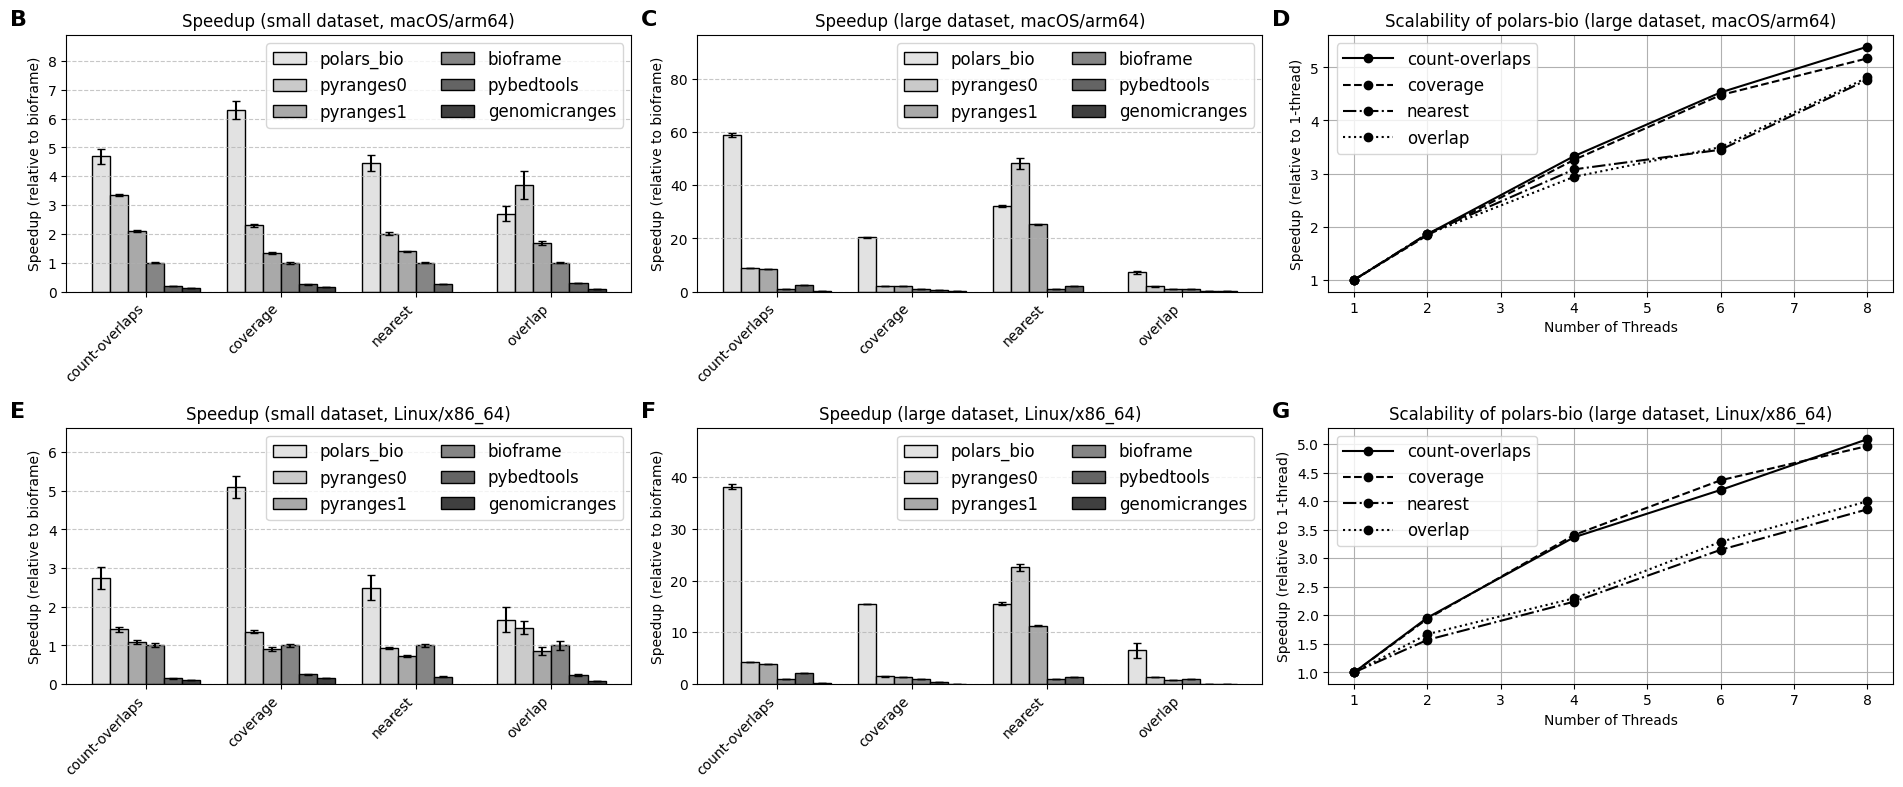

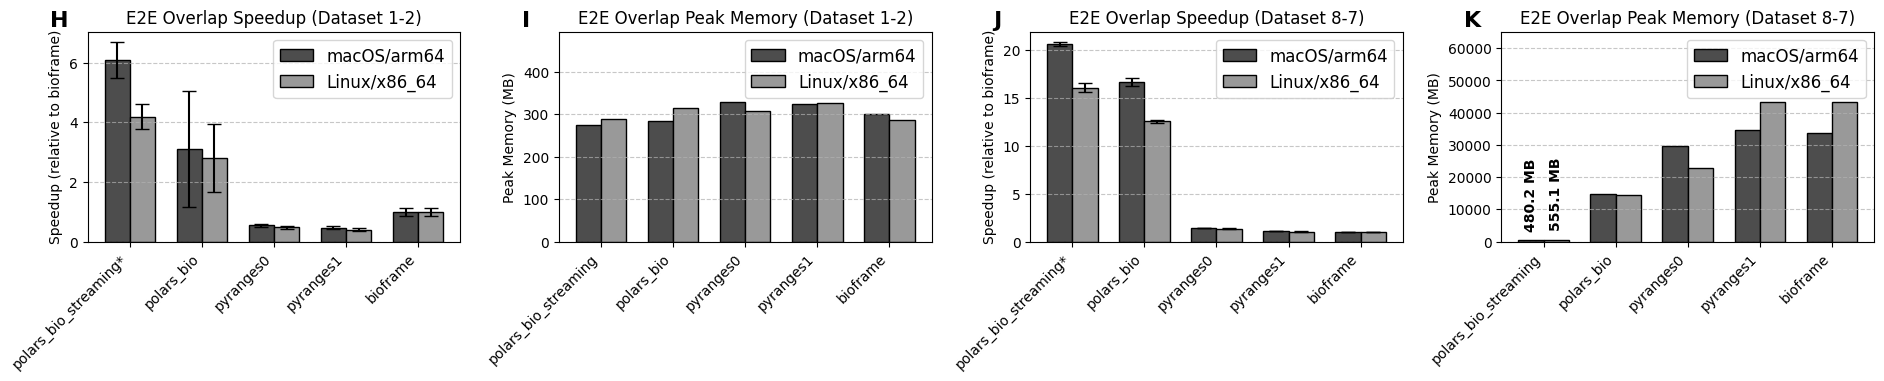

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import svgutils.transform as sg
from svgutils.transform import TextElement

ORDERED_LIBRARIES = [
    "polars_bio_streaming",
    "polars_bio",
    "pyranges0",
    "pyranges1",
    "bioframe",
    "pybedtools",
    "genomicranges",
]
PERFORMANCE_LIBRARIES = [
    "polars_bio",
    "pyranges0",
    "pyranges1",
    "bioframe",
    "pybedtools",
    "genomicranges",
]


def load_benchmark_data(folder_path, dataset):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    data = {}
    for op in operations:
        file_path = os.path.join(folder_path, f"{op}_{dataset}.csv")
        if os.path.exists(file_path):
            data[op] = pd.read_csv(file_path)
    return data


def load_e2e_overlap_data(folder_path, csv_filename):
    file_path = os.path.join(folder_path, csv_filename)
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    return None


def process_e2e_data(df):
    df = df.copy()
    df["Speedup"] = df["Speedup"].str.rstrip("x").astype(float)
    return df


def reorder_df(df, ordered_libs):
    df["Library"] = pd.Categorical(df["Library"], categories=ordered_libs, ordered=True)
    return df.sort_values("Library")


def extract_threads(library_name):
    if library_name == "polars_bio":
        return 1
    parts = library_name.split("-")
    if len(parts) > 1:
        try:
            return int(parts[1])
        except ValueError:
            return None
    return None


def compute_speedup_with_error(data):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    speedup_data = {"Library": [], "Operation": [], "Speedup": [], "Error": []}
    for op in operations:
        if op in data:
            df = data[op]
            bioframe_row = df[df["Library"] == "bioframe"]
            if bioframe_row.empty:
                continue
            mean_bioframe = bioframe_row["Mean (s)"].values[0]
            std_bioframe = (
                bioframe_row["Max (s)"].values[0] - bioframe_row["Min (s)"].values[0]
            ) / 2
            for lib in PERFORMANCE_LIBRARIES:
                tool_row = df[df["Library"] == lib]
                if tool_row.empty:
                    speedup_data["Library"].append(lib)
                    speedup_data["Operation"].append(op)
                    speedup_data["Speedup"].append(None)
                    speedup_data["Error"].append(None)
                else:
                    mean_tool = tool_row["Mean (s)"].values[0]
                    std_tool = (
                        tool_row["Max (s)"].values[0] - tool_row["Min (s)"].values[0]
                    ) / 2
                    speedup = mean_bioframe / mean_tool
                    speedup_error = speedup * np.sqrt(
                        (std_bioframe / mean_bioframe) ** 2
                        + (std_tool / mean_tool) ** 2
                    )
                    speedup_data["Library"].append(lib)
                    speedup_data["Operation"].append(op)
                    speedup_data["Speedup"].append(speedup)
                    speedup_data["Error"].append(speedup_error)
    df_speedup = pd.DataFrame(speedup_data)
    df_speedup["Library"] = pd.Categorical(
        df_speedup["Library"], categories=PERFORMANCE_LIBRARIES, ordered=True
    )
    return df_speedup.sort_values(["Operation", "Library"])


def plot_speedup(ax, data, dataset, operating_system):
    speedup_df = compute_speedup_with_error(data)
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    pivot_speedup = speedup_df.pivot(
        index="Operation", columns="Library", values="Speedup"
    ).reindex(operations)
    pivot_error = speedup_df.pivot(
        index="Operation", columns="Library", values="Error"
    ).reindex(operations)

    x = np.arange(len(operations))
    n_tools = len(PERFORMANCE_LIBRARIES)
    width = 0.8 / n_tools

    colors = [plt.cm.Greys(0.2 + 0.6 * i / (n_tools - 1)) for i in range(n_tools)]

    for i, tool in enumerate(PERFORMANCE_LIBRARIES):
        speedups = pivot_speedup[tool]
        errors = pivot_error[tool]
        offset = (i - n_tools / 2) * width + width / 2
        ax.bar(
            x + offset,
            speedups,
            width,
            yerr=errors,
            capsize=5,
            label=tool,
            color=colors[i],
            edgecolor="black",
            error_kw={"elinewidth": 1.5, "capsize": 3},
        )

    ax.set_xticks(x)
    ax.set_xticklabels(operations, rotation=45, ha="right")
    ax.set_xlabel("")
    ax.set_ylabel("Speedup (relative to bioframe)")
    ax.set_title(f"Speedup ({dataset} dataset, {operating_system})")
    ax.legend(loc="upper right", title="", fontsize=12, ncol=2)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    max_val = max_val = pivot_speedup.max().max()
    max_val_nearest = pivot_speedup.loc["nearest"].max()
    ax.set_ylim(0, max(max_val * 1.3, max_val_nearest * 2))


def plot_scalability(ax, data, operating_system, metric="speedup"):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    line_styles = ["-", "--", "-.", ":"]
    for idx, op in enumerate(operations):
        if op in data:
            df = data[op].copy()
            df = df[df["Library"] != "polars_bio_streaming"]
            df["threads"] = df["Library"].apply(extract_threads)
            df = df.sort_values("threads")
            if metric.lower() == "speedup":
                df["Speedup"] = df["Speedup"].str.rstrip("x").astype(float)
                y = df["Speedup"]
            else:
                y = df["Mean (s)"]
            ax.plot(
                df["threads"],
                y,
                linestyle=line_styles[idx % len(line_styles)],
                marker="o",
                color="black",
                label=op,
            )
    y_label = (
        "Speedup (relative to 1-thread)"
        if metric.lower() == "speedup"
        else "Mean Runtime (s)"
    )
    title = f"Scalability of polars-bio (large dataset, {operating_system})"
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(np.arange(1, 9, 1))
    ax.legend(loc="upper left", ncol=1, fontsize=12, handlelength=3)
    ax.grid(True)


def compute_e2e_speedup_with_error(df):
    speedup_data = {"Library": [], "Speedup": [], "Error": []}
    baseline_row = df[df["Library"] == "bioframe"]
    if baseline_row.empty:
        return pd.DataFrame(speedup_data)
    mean_bioframe = baseline_row["Mean (s)"].values[0]
    std_bioframe = (
        baseline_row["Max (s)"].values[0] - baseline_row["Min (s)"].values[0]
    ) / 2
    for idx, row in df.iterrows():
        lib = row["Library"]

        if pd.isna(row["Speedup"]):
            speedup_data["Library"].append(lib)
            speedup_data["Speedup"].append(None)
            speedup_data["Error"].append(None)
        else:
            mean_tool = row["Mean (s)"]
            std_tool = (row["Max (s)"] - row["Min (s)"]) / 2
            speedup = row["Speedup"]
            error = speedup * np.sqrt(
                (std_bioframe / mean_bioframe) ** 2 + (std_tool / mean_tool) ** 2
            )
            speedup_data["Library"].append(lib)
            speedup_data["Speedup"].append(speedup)
            speedup_data["Error"].append(error)
    return pd.DataFrame(speedup_data)


def plot_e2e_comparison(ax, macos_df, linux_df, metric, title, ylabel):
    if metric.lower() == "speedup":
        macos_speedup = compute_e2e_speedup_with_error(macos_df)
        linux_speedup = compute_e2e_speedup_with_error(linux_df)
        merged = pd.merge(
            macos_speedup,
            linux_speedup,
            on="Library",
            how="outer",
            suffixes=("_macos", "_linux"),
        )
        merged = reorder_df(merged, ORDERED_LIBRARIES)
        x = np.arange(len(merged["Library"]))
        width = 0.35
        macos_color = "0.3"
        linux_color = "0.6"
        ax.bar(
            x - width / 2,
            merged["Speedup_macos"].fillna(0),
            width,
            yerr=merged["Error_macos"].fillna(0),
            capsize=5,
            label="macOS/arm64",
            color=macos_color,
            edgecolor="black",
        )
        ax.bar(
            x + width / 2,
            merged["Speedup_linux"].fillna(0),
            width,
            yerr=merged["Error_linux"].fillna(0),
            capsize=5,
            label="Linux/x86_64",
            color=linux_color,
            edgecolor="black",
        )
    else:
        merged = pd.merge(
            macos_df, linux_df, on="Library", how="outer", suffixes=("_macos", "_linux")
        )
        merged = reorder_df(merged, ORDERED_LIBRARIES)
        x = np.arange(len(merged["Library"]))
        width = 0.35
        macos_color = "0.3"
        linux_color = "0.6"
        ax.bar(
            x - width / 2,
            merged[metric + "_macos"].fillna(0),
            width,
            label="macOS/arm64",
            color=macos_color,
            edgecolor="black",
        )
        ax.bar(
            x + width / 2,
            merged[metric + "_linux"].fillna(0),
            width,
            label="Linux/x86_64",
            color=linux_color,
            edgecolor="black",
        )
    ax.set_xticks(x)
    # ax.set_xticklabels(merged["Library"], rotation=45, ha="right")
    if metric.lower() == "speedup":
        tick_labels = [
            lib + "*" if lib == "polars_bio_streaming" else lib
            for lib in merged["Library"]
        ]
    else:
        tick_labels = merged["Library"]
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    col_macos = metric + "_macos"
    col_linux = metric + "_linux"
    if metric.lower().startswith("peak memory"):  # scale y-axis for peak memory
        max_val = merged[[col_macos, col_linux]].max().max()
        ax.set_ylim(0, max_val * 1.5)
        if title.endswith("Dataset 8-7)"):  # additional annotation only for dataset 8-7
            idx = merged.index[merged["Library"] == "polars_bio_streaming"]
            if not idx.empty:
                pos = np.where(merged["Library"] == "polars_bio_streaming")[0][0]
                x_pos = x[pos]
                y_val_macos = merged.loc[merged.index[pos], col_macos]
                y_val_linux = merged.loc[merged.index[pos], col_linux]
                if pd.notna(y_val_macos):
                    offset = y_val_macos * 5
                    ax.text(
                        x_pos - width / 2,
                        y_val_linux + offset,
                        f"{y_val_linux:.1f} MB",
                        transform=ax.transData,
                        ha="center",
                        va="bottom",
                        fontsize=10,
                        fontweight="bold",
                        color="black",
                        rotation=90,
                    )
                    ax.text(
                        x_pos + width / 2,
                        y_val_macos + offset,
                        f"{y_val_macos:.1f} MB",
                        transform=ax.transData,
                        ha="center",
                        va="bottom",
                        fontsize=10,
                        fontweight="bold",
                        color="black",
                        rotation=90,
                    )


paper_folder_path = "../results/paper"
figures_path = "figures/"

apple_m3_max_folder_path = os.path.join(paper_folder_path, "apple-m3-max")
gcp_linux_folder_path = os.path.join(paper_folder_path, "gcp-linux")
apple_m3_max_8_7_folder_path = os.path.join(apple_m3_max_folder_path, "8-7")
apple_m3_max_8_7_parallel_folder_path = os.path.join(
    apple_m3_max_folder_path, "8-7-parallel"
)
apple_m3_max_1_2_folder_path = os.path.join(apple_m3_max_folder_path, "1-2")
apple_m3_max_7_8_folder_path = os.path.join(apple_m3_max_folder_path, "7-8")
gcp_linux_1_2_folder_path = os.path.join(gcp_linux_folder_path, "1-2")
gcp_linux_7_8_folder_path = os.path.join(gcp_linux_folder_path, "7-8")
gcp_linux_8_7_folder_path = os.path.join(gcp_linux_folder_path, "8-7")
gcp_linux_8_7_parallel_folder_path = os.path.join(gcp_linux_folder_path, "8-7-parallel")

macos_1_2_data = load_benchmark_data(apple_m3_max_1_2_folder_path, "1-2")
macos_7_8_data = load_benchmark_data(apple_m3_max_7_8_folder_path, "7-8")
macos_8_7_data = load_benchmark_data(apple_m3_max_8_7_folder_path, "8-7")
linux_1_2_data = load_benchmark_data(gcp_linux_1_2_folder_path, "1-2")
linux_7_8_data = load_benchmark_data(gcp_linux_7_8_folder_path, "7-8")
linux_8_7_data = load_benchmark_data(gcp_linux_8_7_folder_path, "8-7")
macos_8_7_parallel_data = load_benchmark_data(
    apple_m3_max_8_7_parallel_folder_path, "8-7"
)
linux_8_7_parallel_data = load_benchmark_data(gcp_linux_8_7_parallel_folder_path, "8-7")

macos_e2e_1_2 = load_e2e_overlap_data(
    apple_m3_max_folder_path, "e2e-overlap-csv/e2e-overlap-csv_1-2.csv"
)
linux_e2e_1_2 = load_e2e_overlap_data(
    gcp_linux_folder_path, "e2e-overlap-csv/e2e-overlap-csv_1-2.csv"
)
macos_e2e_8_7 = load_e2e_overlap_data(
    apple_m3_max_folder_path, "e2e-overlap-csv/e2e-overlap-csv_8-7.csv"
)
linux_e2e_8_7 = load_e2e_overlap_data(
    gcp_linux_folder_path, "e2e-overlap-csv/e2e-overlap-csv_8-7.csv"
)

if macos_e2e_1_2 is not None:
    macos_e2e_1_2 = process_e2e_data(macos_e2e_1_2)
if linux_e2e_1_2 is not None:
    linux_e2e_1_2 = process_e2e_data(linux_e2e_1_2)
if macos_e2e_8_7 is not None:
    macos_e2e_8_7 = process_e2e_data(macos_e2e_8_7)
if linux_e2e_8_7 is not None:
    linux_e2e_8_7 = process_e2e_data(linux_e2e_8_7)

performance_plots = [
    {
        "func": plot_speedup,
        "data": macos_1_2_data,
        "dataset": "small",
        "os": "macOS/arm64",
    },
    {
        "func": plot_speedup,
        "data": macos_8_7_data,
        "dataset": "large",
        "os": "macOS/arm64",
    },
    {
        "func": plot_scalability,
        "data": macos_8_7_parallel_data,
        "dataset": "8-7",
        "os": "macOS/arm64",
        "metric": "speedup",
    },
    {
        "func": plot_speedup,
        "data": linux_1_2_data,
        "dataset": "small",
        "os": "Linux/x86_64",
    },
    {
        "func": plot_speedup,
        "data": linux_8_7_data,
        "dataset": "large",
        "os": "Linux/x86_64",
    },
    {
        "func": plot_scalability,
        "data": linux_8_7_parallel_data,
        "dataset": "8-7",
        "os": "Linux/x86_64",
        "metric": "speedup",
    },
]

fig_perf, axs_perf = plt.subplots(2, 3, figsize=(19, 8))
axs_perf = axs_perf.flatten()
panel_labels_perf = ["B", "C", "D", "E", "F", "G"]

for ax, plot_def, label in zip(axs_perf, performance_plots, panel_labels_perf):
    if plot_def["func"] == plot_speedup:
        plot_speedup(ax, plot_def["data"], plot_def["dataset"], plot_def["os"])
    elif plot_def["func"] == plot_scalability:
        metric = plot_def.get("metric", "speedup")
        plot_scalability(ax, plot_def["data"], plot_def["os"], metric=metric)
    ax.text(
        -0.1,
        1.1,
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="left",
    )

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "performance.svg"), format="svg")

e2e_plots = [
    {
        "title": "E2E Overlap Speedup (small dataset)",
        "macos": macos_e2e_1_2,
        "linux": linux_e2e_1_2,
        "metric": "Speedup",
        "ylabel": "Speedup (relative to bioframe)",
    },
    {
        "title": "E2E Overlap Peak Memory (small dataset)",
        "macos": macos_e2e_1_2,
        "linux": linux_e2e_1_2,
        "metric": "Peak memory (MB)",
        "ylabel": "Peak Memory (MB)",
    },
    {
        "title": "E2E Overlap Speedup (large dataset)",
        "macos": macos_e2e_8_7,
        "linux": linux_e2e_8_7,
        "metric": "Speedup",
        "ylabel": "Speedup (relative to bioframe)",
    },
    {
        "title": "E2E Overlap Peak Memory (large dataset)",
        "macos": macos_e2e_8_7,
        "linux": linux_e2e_8_7,
        "metric": "Peak memory (MB)",
        "ylabel": "Peak Memory (MB)",
    },
]

fig_e2e, axs_e2e = plt.subplots(1, 4, figsize=(19, 4))
panel_labels_e2e = ["H", "I", "J", "K"]

for ax, plot_def, label in zip(axs_e2e, e2e_plots, panel_labels_e2e):
    if plot_def["macos"] is not None and plot_def["linux"] is not None:
        plot_e2e_comparison(
            ax,
            plot_def["macos"],
            plot_def["linux"],
            plot_def["metric"],
            plot_def["title"],
            plot_def["ylabel"],
        )
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(plot_def["title"])
    ax.text(
        -0.1,
        1.1,
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="left",
    )

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "e2e_performance.svg"), format="svg")


plot1 = sg.fromfile(os.path.join(figures_path, "polars-bio-paper-v2.svg")).getroot()
plot2 = sg.fromfile(os.path.join(figures_path, "performance.svg")).getroot()
plot3 = sg.fromfile(os.path.join(figures_path, "e2e_performance.svg")).getroot()
plot4 = sg.fromfile(
    os.path.join(figures_path, "polars-bio-paper-flow-diagram-v2.svg")
).getroot()
text_A = TextElement(10, 30, "A", size="17px", weight="bold")
text_L = TextElement(10, 30, "L", size="17px", weight="bold")

new_plot1 = sg.GroupElement([plot1, text_A])
new_plot4 = sg.GroupElement([plot4, text_L])

new_plot1.moveto(0, 0)
plot2.moveto(0, 400)
plot3.moveto(0, 970)
new_plot4.moveto(0, 1270)
fig_combined = sg.SVGFigure("1400", "1900")
fig_combined.root.set("viewBox", "0 0 1400 1740")
fig_combined.append([new_plot1, plot2, plot3, new_plot4])
fig_combined.save(os.path.join(figures_path, "combined.svg"))

In [ ]:
!inkscape -o figures/combined.pdf figures/combined.svg